## Transfer Learning with TensorFlow Part 2: Fine-tunning

In the previous notebook, we covered transfer learing features extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

In [1]:
# chechk if we are using a GPU
!nvidia-smi

Fri Oct 22 12:25:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.12       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8     9W /  N/A |    134MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating Helper functions
In the previous, we've created a bunch of helper functions, now we could write them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere)


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-22 12:25:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.5'

     0K ..........                                            100% 2.54M=0.004s

2021-10-22 12:25:35 (2.54 MB/s) - 'helper_functions.py.5' saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this  notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir 

>🔑**Note:** if you're running this notebook in Google Colab, when it times out Colab will automatically will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models with `tf.keras.application` and apply them to our own probelm (recognizing image of food).

link:https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get the 10% training data of classes of food101
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percen

In [5]:
# Create training and test directory paths 
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [6]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_precent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                         image_size = IMG_SIZE,
                                                                         label_mode= "categorical",
                                                                         batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size= IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE) 
                                                                      

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_precent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [8]:
# Check out the class names of our dataset
train_data_10_precent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# see an example of a batch of data
for images, labels in train_data_10_precent.take(1):
    print(images, labels)

tf.Tensor(
[[[[2.15051022e+01 3.55051003e+01 4.45051003e+01]
   [1.88367348e+01 3.28367348e+01 4.18367348e+01]
   [2.22653065e+01 3.52653046e+01 4.42653046e+01]
   ...
   [4.18009758e+01 6.08009758e+01 9.38009720e+01]
   [2.99744854e+01 4.89744835e+01 8.19744873e+01]
   [3.55868988e+01 5.45868988e+01 8.75868988e+01]]

  [[2.31224480e+01 3.51275520e+01 4.44591827e+01]
   [3.20051041e+01 4.48061256e+01 5.38724518e+01]
   [2.52908173e+01 3.76479568e+01 4.68622437e+01]
   ...
   [3.47142410e+01 5.30714493e+01 8.62857132e+01]
   [3.29285851e+01 5.18622475e+01 8.50612640e+01]
   [3.71939850e+01 5.51939850e+01 9.11939850e+01]]

  [[2.18520412e+01 2.94234695e+01 4.26377525e+01]
   [3.10612240e+01 3.90306129e+01 5.20459175e+01]
   [2.76224499e+01 3.72397957e+01 4.95459175e+01]
   ...
   [3.28877296e+01 4.88877296e+01 8.44592056e+01]
   [3.44132614e+01 5.17704048e+01 8.99846878e+01]
   [2.98009033e+01 4.78009033e+01 8.62294769e+01]]

  ...

  [[1.21479731e+01 7.57650089e+00 1.79076505e+00]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API
The sequential API is a straight-forward, it runs our layers in sequential order.

But the functional API gives more flexibility with our models.

In [10]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False) 

# 2. Freeze the base model(so the underlying pre-trained patterns aren't updated during trainig)
base_model.trainable =False 

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224, 224, 3) , name = "input_layer")

# 4. If using a model like ResNet5OV2 you will need to normalize inputs (you don't have to for EfficientNet's)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing the inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_avareage_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name ="output_layers")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9.compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model and save its history
hsitory_0 = model_0.fit(train_data_10_precent,
                         epochs = 5,
                         steps_per_epoch = len(train_data_10_precent),
                         validation_data = test_data,
                         validation_steps = int(0.25 * len(test_data)),
                         callbacks = [create_tensorboard_callback(dir_name ="transfer_learnong", 
                                                                  experiment_name = "10_per_feature_extraction")])




Shape after passing the inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learnong/10_per_feature_extraction/20211022-122541


C:\Users\prash\anaconda3\envs\CudaT\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 12s 269ms/step - loss: 1.9295 - accuracy: 0.3733 - val_loss: 1.3295 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - 5s 192ms/step - loss: 1.1598 - accuracy: 0.7427 - val_loss: 0.9333 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - 5s 194ms/step - loss: 0.8413 - accuracy: 0.8107 - val_loss: 0.7591 - val_accuracy: 0.8174
Epoch 4/5
24/24 [==============================] - 5s 192ms/step - loss: 0.6974 - accuracy: 0.8373 - val_loss: 0.6781 - val_accuracy: 0.8339
Epoch 5/5
24/24 [==============================] - 5s 193ms/step - loss: 0.5855 - accuracy: 0.8587 - val_loss: 0.5800 - val_accuracy: 0.8438


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 111ms/step - loss: 0.6082 - accuracy: 0.8376


[0.6082184314727783, 0.8375999927520752]

In [12]:
# check the layers in our base model
for layer_number, layer in enumerate (base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
# getting summary of the base model 
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [14]:
# Getting summary of whole model
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avareage_pooling_laye (None, 1280)              0         
_________________________________________________________________
output_layers (Dense)        (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


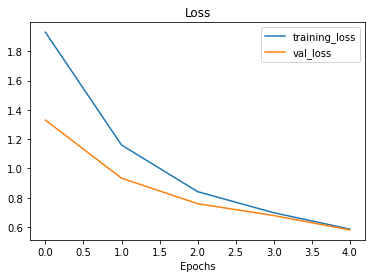

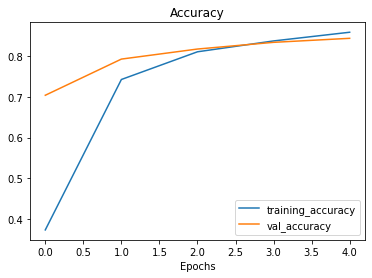

In [15]:
# Check out the model's training loss curves
plot_loss_curves(hsitory_0)

## Getting a feature vector from a trained model 

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape(None, 7, 7, 280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [16]:
# Define the input shape 
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tesnor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tesnor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average tensor pooled random tesnor:\n {global_average_pooled_tesnor}\n")

# Check the shape of the different tensors
print(f"Shape of the input tensor: {input_tensor.shape}" )
print(f"Shape of the Global Average Pooled 2D tesnor: {global_average_pooled_tesnor.shape}")

Random input tesnor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average tensor pooled random tesnor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of the input tensor: (1, 4, 4, 3)
Shape of the Global Average Pooled 2D tesnor: (1, 3)


In [17]:
# Let's reaplicate the GlobalAveragePool2D
tf.reduce_mean(input_tensor, axis =[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

>**Note:** One of the reasons feature extraction tranfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represent the learned respresentation of the model on a particular sample, in our case, this is the output of the`tf.keras.layers.GlobalAveragePooling2D()` layer) which can be then be used to extract patterns out of for our own specific problem.

## Running a series of transfer learing experiments

We've seen the incredible results transfer learing can get with only 10% of the training data, but how does it go wiht 1% of the training data... how about we set up a bunch of experiments to find out:
1. `model_1` - use feature extraction transfer learing with 1% of the trainig data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning tranfer learning on 100% of the training data with data augmentation.

🔑**Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensure consistency across evaltuation.

### Getting and preprocessing data for model_1

In [18]:
# Download and unzip data - preprocessed from Food101 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
    
unzip_data("10_food_classes_1_percent.zip")

--2021-10-22 12:26:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.42.80, 172.217.27.208, 172.217.160.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.42.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: '10_food_classes_1_percent.zip.3'

     0K .......... .......... .......... .......... ..........  0%  955K 2m17s
    50K .......... .......... .......... .......... ..........  0% 1.81M 1m43s
   100K .......... .......... .......... .......... ..........  0% 2.87M 84s
   150K .......... .......... .......... .......... ..........  0% 4.41M 70s
   200K .......... .......... .......... .......... ..........  0% 3.94M 62s
   250K .......... .......... .......... .......... ..........  0% 4.08M 57s
   300K .......... .......... .......... .......... ..........  0% 5.46M 52s
 

124650K .......... .......... .......... .......... .......... 95%  624M 1s
124700K .......... .......... .......... .......... .......... 95% 1.96M 1s
124750K .......... .......... .......... .......... .......... 95%  757M 1s
124800K .......... .......... .......... .......... .......... 95%  648M 1s
124850K .......... .......... .......... .......... .......... 95%  294M 1s
124900K .......... .......... .......... .......... .......... 95% 1.73M 1s
124950K .......... .......... .......... .......... .......... 95%  704M 1s
125000K .......... .......... .......... .......... .......... 95%  267M 1s
125050K .......... .......... .......... .......... .......... 95%  480M 1s
125100K .......... .......... .......... .......... .......... 95% 2.12M 1s
125150K .......... .......... .......... .......... .......... 95%  518M 1s
125200K .......... .......... .......... .......... .......... 95% 2.36M 1s
125250K .......... .......... .......... .......... .......... 96%  230M 1s
125300K ....

In [19]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [20]:
#How many images are we working with
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [21]:
# Setup data loders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = 32)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                        label_mode = "categorical",
                                                                        image_size = IMG_SIZE,
                                                                         batch_size = 32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model 

To add data augmentation right into our models, we can use the layers inside:
    
* `tf.keras.layers.experimental.preprocessing()`

off the top our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmented them) happens on the GPU (much faster) rather than the CPU whereas `ImageDataGenerator` augments the images on CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [22]:
print(tf.__version__)

2.6.0


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    #preprocessing.Rescale(1/255.) # Keep for models like ResNet50V2 but EfficientNet's having rescaling build-in
], name = "data_augmentation" )



### Visualize our data augmentation layer (and see what happens to out data)

[[[ 35   1   0]
  [ 35   1   0]
  [ 35   1   0]
  ...
  [252 255 255]
  [252 255 255]
  [252 255 255]]

 [[ 35   1   0]
  [ 35   1   0]
  [ 35   1   0]
  ...
  [252 255 255]
  [252 255 255]
  [252 255 255]]

 [[ 35   1   0]
  [ 35   1   0]
  [ 35   1   0]
  ...
  [252 255 255]
  [252 255 255]
  [252 255 255]]

 ...

 [[252 255 255]
  [252 255 255]
  [252 255 255]
  ...
  [252 255 255]
  [255 255 255]
  [254 254 254]]

 [[249 255 255]
  [249 255 255]
  [249 255 255]
  ...
  [248 252 251]
  [252 252 252]
  [253 253 253]]

 [[251 255 255]
  [251 255 255]
  [251 255 255]
  ...
  [252 255 255]
  [251 251 251]
  [253 253 253]]]
tf.Tensor(
[[[[175.        109.         17.       ]
   [175.        108.08302    17.916975 ]
   [175.        107.138374   17.138376 ]
   ...
   [153.58481    92.58481     1.8616028]
   [150.75089    89.750885    1.0830383]
   [148.         87.          2.       ]]

  [[175.        108.23267    15.465346 ]
   [173.59276   105.90846    14.975082 ]
   [174.12648   105.49

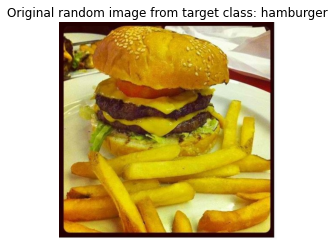

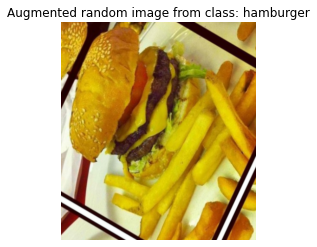

In [24]:
# View a ranodm image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from target class: {target_class}")
plt.axis(False)
print(img)

# Now let's plot our augmented random image
augmented_image = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f'Augmented random image from class: {target_class}')
plt.axis(False)
print(augmented_image)

## Model_1: Feature extraction transfer learning on 1% of the data with data augumentiaon

In [25]:
# Setup input shape and base model, freezing the base model layer
input_shape = (224, 224, 3)
base_model= tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape = input_shape, name =" input_layer")

# Ad in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name = "global_average_poolig_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10 , activation ='softmax', name = "output_layer")(x)

# Make a model using the inputs and ouputs
model_1 = keras.Model(inputs, outputs)

# compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# train the model 
history_1_percent = model_1.fit(train_data_1_percent ,
                               epochs = 5,
                               steps_per_epoch = len(train_data_1_percent),
                               validation_data = test_data,
                               validation_steps = int(0.25* len(test_data)),
                               callbacks = [create_tensorboard_callback(dir_name = "tranfer_learning",
                                                                        experiment_name = "1_percent_data_augmentation")])
 

Saving TensorBoard log files to: tranfer_learning/1_percent_data_augmentation/20211022-122647
Epoch 1/5
3/3 [==============================] - 9s 2s/step - loss: 2.3769 - accuracy: 0.1143 - val_loss: 2.2154 - val_accuracy: 0.1743
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1525 - accuracy: 0.2286 - val_loss: 2.1144 - val_accuracy: 0.2138
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9537 - accuracy: 0.3286 - val_loss: 2.0148 - val_accuracy: 0.2878
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8077 - accuracy: 0.5000 - val_loss: 1.9238 - val_accuracy: 0.3553
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6183 - accuracy: 0.7143 - val_loss: 1.8109 - val_accuracy: 0.4490


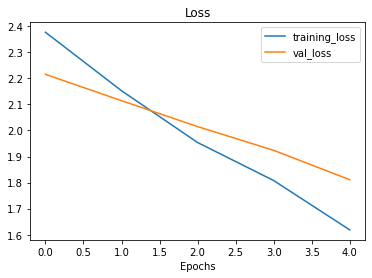

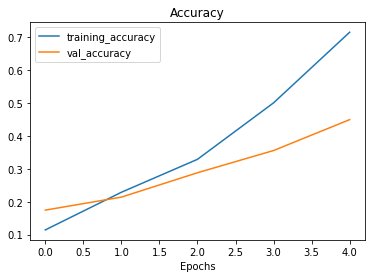

In [26]:
# let's see the loss curves
plot_loss_curves(history_1_percent)

In [27]:
# Evaluate on the full test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 9s 111ms/step - loss: 1.8395 - accuracy: 0.4184


[1.8395193815231323, 0.41839998960494995]

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation


In [28]:
# Get 10% of the data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data(10_food_classes_10_percent)

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir_10_percent = "10_food_classes_10_percent/test"

In [46]:
# set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [48]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1/255.) #if you're using model such as ResNet50V2, you'll need to rescale your data, efficientnet has rescaling built-in
], name = "data_aaugmentation")

# setup the imput shape to our model
input_shape = (224, 224, 3)

# Create a frozen bse model (also called the backbone) 
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape= input_shape , name = "input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in infrence mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation = "softmax", name= "output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model 
model_2.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])



### Creating a ModelCheckPoint Callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.


In [51]:
# set checkpoint path
checkpoint_path = "ten_percent_mdoel_chechkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch", #save every epoch
                                                         verbose = 1 )

In [61]:
# Fit the model
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = len(test_data),
                        callbacks = [create_tensorboard_callback(dir_name ="transfer_learning",
                                                                 experiment_name ="10_percent_data_aug"),
                                                                 checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20211022-134003
Epoch 1/5
24/24 [==============================] - 17s 696ms/step - loss: 0.4187 - accuracy: 0.8907 - val_loss: 0.5089 - val_accuracy: 0.8372

Epoch 00001: saving model to ten_percent_mdoel_chechkpoint_weights\checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 16s 664ms/step - loss: 0.3995 - accuracy: 0.9067 - val_loss: 0.5143 - val_accuracy: 0.8364

Epoch 00002: saving model to ten_percent_mdoel_chechkpoint_weights\checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 15s 624ms/step - loss: 0.3782 - accuracy: 0.9120 - val_loss: 0.5021 - val_accuracy: 0.8372

Epoch 00003: saving model to ten_percent_mdoel_chechkpoint_weights\checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 15s 659ms/step - loss: 0.3579 - accuracy: 0.9240 - val_loss: 0.5016 - val_accuracy: 0.8384

Epoch 00004: saving model to ten_percent_mdoel_chechkpoint_weights\checkpoint.ckpt
Epoch 5/5

In [58]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 9s 114ms/step - loss: 0.6082 - accuracy: 0.8376


[0.6082180738449097, 0.8375999927520752]

In [64]:
# check model_2 results on test_data
results_10_prercent_aug = model_2.evaluate(test_data)

79/79 [==============================] - 8s 105ms/step - loss: 0.4978 - accuracy: 0.8328


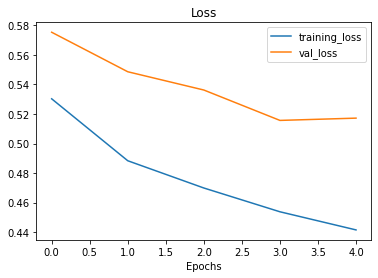

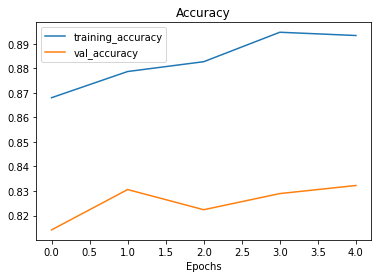

In [60]:
# Plot model_loss curves
plot_loss_curves(history_2)

### Loading in checkpoint weights

Loading in checkpointed weights return a model to specific checkpoint

In [62]:
# Load in saved model weights and evaluate model 
model_2.load_weights(checkpoint_path)

In [63]:
# Evaluate model_2 with loaded weitghts
loaded_weights_model_results  = model_2.evaluate(test_data)

79/79 [==============================] - 9s 111ms/step - loss: 0.4978 - accuracy: 0.8328


In [66]:
# If the results form our previously evaluated model_2 match the loaeded weights, everything has worked!
results_10_prercent_aug  == loaded_weights_model_results

False

In [67]:
results_10_prercent_aug

[0.49777212738990784, 0.8327999711036682]

In [68]:
loaded_weights_model_results

[0.4977719783782959, 0.8327999711036682]

In [69]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_prercent_aug), np.array(loaded_weights_model_results))

array([ True,  True])

## Model 3: Fine-tuning an existing model on 10% of the data

>🔑**Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [70]:
# Layers in model model
model_2.layers

In [71]:
# are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001C9878A67F0> True
<keras.engine.sequential.Sequential object at 0x000001C96940B0B8> True
<keras.engine.functional.Functional object at 0x000001C9DC691E80> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x000001C9DAAB2518> True
<keras.layers.core.Dense object at 0x000001C9DC8C04E0> True


In [79]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_9 False
1 rescaling_8 False
2 normalization_8 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [80]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [83]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_mdoel.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10 layer
for layer in base_model.layers[:-10]:
    layer.trainable = False
    
# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss = 'categorical_crossentropy',
                optimizer  = tf.keras.optimizers.Adam(learning_rate = 0.0001), # when fine tuning you typically want to lower the learning rate by 10x
                metrics =['accuracy'])


>🔑**Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x(though different sources will claim other value)
A good resource for information on this is the ULMFIT paper: [Paper](  https://arxiv.org/abs/1801.06146)


In [85]:
# Check which layer are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_9 False
1 rescaling_8 False
2 normalization_8 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [86]:
# Now we've unfrozen some of the layer closser ot the top, how many trainable variable are there?
print(len(model_2.trainable_variables))

12


In [87]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [95]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5


# Refit the model (same as model_2 except with more trainable layer)
history_3 = model_2.fit( train_data_10_percent,
                        epochs = fine_tune_epochs ,
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        initial_epoch = history_2.epoch[-1], #start training from previous last epochs
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                 experiment_name = "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20211022-152254
Epoch 5/10


C:\Users\prash\anaconda3\envs\CudaT\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 16s 483ms/step - loss: 0.3181 - accuracy: 0.9120 - val_loss: 0.5205 - val_accuracy: 0.8174
Epoch 6/10
24/24 [==============================] - 9s 388ms/step - loss: 0.2550 - accuracy: 0.9347 - val_loss: 0.5131 - val_accuracy: 0.8191
Epoch 7/10
24/24 [==============================] - 9s 375ms/step - loss: 0.2588 - accuracy: 0.9173 - val_loss: 0.4684 - val_accuracy: 0.8257
Epoch 8/10
24/24 [==============================] - 10s 403ms/step - loss: 0.2116 - accuracy: 0.9347 - val_loss: 0.4883 - val_accuracy: 0.8273
Epoch 9/10
24/24 [==============================] - 9s 377ms/step - loss: 0.1713 - accuracy: 0.9413 - val_loss: 0.4506 - val_accuracy: 0.8520
Epoch 10/10
24/24 [==============================] - 8s 354ms/step - loss: 0.1557 - accuracy: 0.9627 - val_loss: 0.4842 - val_accuracy: 0.8355


In [96]:
# Evaluate the fine-tuned model (model_3 which is acctualy mdoel_2 fine_tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 8s 105ms/step - loss: 0.4820 - accuracy: 0.8460


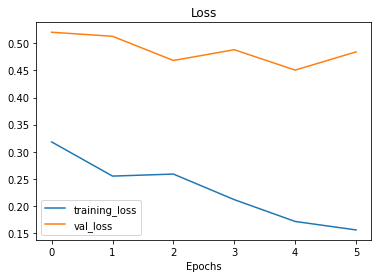

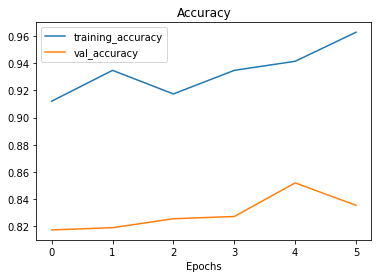

In [97]:
# check the loss curves
plot_loss_curves(history_3)

The `plot_loss_curves` function works great with models which have only been fit once, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning). 

In [136]:
# Let's create a function to compare training histories
def compare_history(original_history, new_history, initial_epochs = 5):
    """
    Compares two TensorFlow History objects.
    """
    # Get original history measurement
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    
    val_acc= original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]
    
    # Combine original history metrics with new_history metrics
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history["loss"]
    
    total_val_acc= val_acc + new_history.history["val_accuracy"]
    total_val_loss =  val_loss + new_history.history["val_loss"]
    
    %matplotlib inline
    # Make plots for accuracy 
    plt.figure(figsize = (8,8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label= "total_accuracy")
    plt.plot(total_val_acc, label = "val_accuray")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
    plt.legend(loc ="lower right")
    plt.title("Training and Validation Accuracy")
    
    
    # Make plots for loss
    plt.figure(figsize = (8,8))
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label= "total_loss")
    plt.plot(total_val_loss, label = "val_loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
    plt.legend(loc ="upper right")
    plt.title("Training and Validation loss")
    

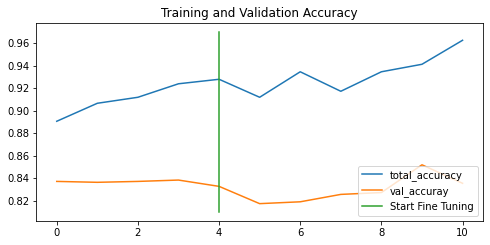

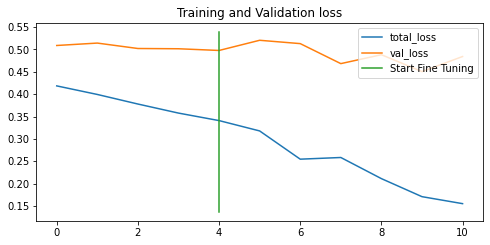

In [138]:
compare_history(history_2, history_3, initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data

In [140]:
# Donwload and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-10-22 16:41:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.166.208, 172.217.166.240, 172.217.167.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.166.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: '10_food_classes_all_data.zip'

     0K .......... .......... .......... .......... ..........  0% 3.10M 2m40s
    50K .......... .......... .......... .......... ..........  0% 4.95M 2m10s
   100K .......... .......... .......... .......... ..........  0% 9.35M 1m44s
   150K .......... .......... .......... .......... ..........  0% 10.7M 90s
   200K .......... .......... .......... .......... ..........  0% 9.97M 82s
   250K .......... .......... .......... .......... ..........  0% 21.9M 72s
   300K .......... .......... .......... .......... ..........  0% 9.66M 69s

 49650K .......... .......... .......... .......... ..........  9% 3.69M 79s
 49700K .......... .......... .......... .......... ..........  9% 5.47M 79s
 49750K .......... .......... .......... .......... ..........  9% 4.29M 79s
 49800K .......... .......... .......... .......... ..........  9% 22.0M 79s
 49850K .......... .......... .......... .......... ..........  9% 6.29M 79s
 49900K .......... .......... .......... .......... ..........  9% 13.6M 79s
 49950K .......... .......... .......... .......... ..........  9% 2.78M 79s
 50000K .......... .......... .......... .......... ..........  9% 16.5M 79s
 50050K .......... .......... .......... .......... ..........  9% 6.30M 79s
 50100K .......... .......... .......... .......... ..........  9% 5.19M 79s
 50150K .......... .......... .......... .......... ..........  9% 2.37M 79s
 50200K .......... .......... .......... .......... ..........  9%  367M 79s
 50250K .......... .......... .......... .......... ..........  9%  410M 79s

174600K .......... .......... .......... .......... .......... 34% 8.41M 57s
174650K .......... .......... .......... .......... .......... 34% 9.08M 57s
174700K .......... .......... .......... .......... .......... 34% 1.96M 57s
174750K .......... .......... .......... .......... .......... 34%  169M 57s
174800K .......... .......... .......... .......... .......... 34% 3.89M 57s
174850K .......... .......... .......... .......... .......... 34%  402M 57s
174900K .......... .......... .......... .......... .......... 34% 72.6M 57s
174950K .......... .......... .......... .......... .......... 34% 1.32M 57s
175000K .......... .......... .......... .......... .......... 34%  323M 57s
175050K .......... .......... .......... .......... .......... 34%  631M 57s
175100K .......... .......... .......... .......... .......... 34% 4.30M 57s
175150K .......... .......... .......... .......... .......... 34%  309M 57s
175200K .......... .......... .......... .......... .......... 34% 4.44M 57s

310650K .......... .......... .......... .......... .......... 61% 7.09M 35s
310700K .......... .......... .......... .......... .......... 61% 7.11M 35s
310750K .......... .......... .......... .......... .......... 61% 7.55M 35s
310800K .......... .......... .......... .......... .......... 61% 7.94M 35s
310850K .......... .......... .......... .......... .......... 61% 8.62M 34s
310900K .......... .......... .......... .......... .......... 61% 7.24M 34s
310950K .......... .......... .......... .......... .......... 61% 6.15M 34s
311000K .......... .......... .......... .......... .......... 61% 8.01M 34s
311050K .......... .......... .......... .......... .......... 61% 8.34M 34s
311100K .......... .......... .......... .......... .......... 61% 8.32M 34s
311150K .......... .......... .......... .......... .......... 61% 8.54M 34s
311200K .......... .......... .......... .......... .......... 61% 8.11M 34s
311250K .......... .......... .......... .......... .......... 61% 4.07M 34s

449550K .......... .......... .......... .......... .......... 88% 5.17M 10s
449600K .......... .......... .......... .......... .......... 88% 7.22M 10s
449650K .......... .......... .......... .......... .......... 88% 8.05M 10s
449700K .......... .......... .......... .......... .......... 88% 8.89M 10s
449750K .......... .......... .......... .......... .......... 88% 6.54M 10s
449800K .......... .......... .......... .......... .......... 88% 3.25M 10s
449850K .......... .......... .......... .......... .......... 88%  405M 10s
449900K .......... .......... .......... .......... .......... 88% 16.3M 10s
449950K .......... .......... .......... .......... .......... 88% 1.02M 10s
450000K .......... .......... .......... .......... .......... 88%  473M 10s
450050K .......... .......... .......... .......... .......... 88% 69.5M 10s
450100K .......... .......... .......... .......... .......... 88%  327M 10s
450150K .......... .......... .......... .......... .......... 88%  595M 10s

In [141]:
# Setup training and test_dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [142]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [143]:
# setup data inputs
import tensorflow as tf
input_shape = (224, 224)

train_data_10_percent_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode = "categorical",
                                                                                 image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

                                                          

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [144]:
# Evaluate model 2 ( This is the fine tune on 10 percent of data verison)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 111ms/step - loss: 0.4820 - accuracy: 0.8460


[0.482021301984787, 0.8460000157356262]

To Train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [145]:
# Load weights from checkpoints, that way we can fine-tune from 
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [146]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 9s 112ms/step - loss: 0.4978 - accuracy: 0.8328


[0.497772216796875, 0.8327999711036682]

In [147]:
# check to see if our model_2 has been reverted back to feature extraction results
results_10_prercent_aug

[0.49777212738990784, 0.8327999711036682]

Alright, the previous steps seem quite confusing but all we've done is :

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weight using `ModelCheckpoint` callback.
2. Fine-tune the same model on the same 10% of the data for a further 5 epochs with the top 10 layer of the base model unfrozen (model_3).
3. saved the results and training logs each time.
4. Reloaded the model form step 1 to do the same steps as step 2 except this time we're going to use all of the data(model_4)

In [148]:
# check which layer are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [150]:
#Let's drill into our base_model (efficientNetB0) and see what layers are trainable 
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_9 False
1 rescaling_8 False
2 normalization_8 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [151]:
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])



In [156]:
# Continue to train and fine-tune the model to our data (100% of the training data)
fine_tune_epochs = initial_epochs + 5

history_4 = model_2.fit(train_data_10_percent_full,
                       epochs = fine_tune_epochs,
                       validation_data = test_data,
                       validation_steps =int(0.25* len(test_data)),
                       initial_epoch = history_2.epoch[-1],
                       callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                experiment_name = "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20211022-212157
Epoch 5/10


C:\Users\prash\anaconda3\envs\CudaT\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 60s 256ms/step - loss: 0.5429 - accuracy: 0.8233 - val_loss: 0.3688 - val_accuracy: 0.8832
Epoch 6/10
235/235 [==============================] - 56s 236ms/step - loss: 0.4881 - accuracy: 0.8424 - val_loss: 0.3811 - val_accuracy: 0.8816
Epoch 7/10
235/235 [==============================] - 53s 224ms/step - loss: 0.4334 - accuracy: 0.8628 - val_loss: 0.3117 - val_accuracy: 0.9046
Epoch 8/10
235/235 [==============================] - 50s 213ms/step - loss: 0.3941 - accuracy: 0.8737 - val_loss: 0.3257 - val_accuracy: 0.9013
Epoch 9/10
235/235 [==============================] - 47s 201ms/step - loss: 0.3692 - accuracy: 0.8799 - val_loss: 0.3398 - val_accuracy: 0.8947
Epoch 10/10
235/235 [==============================] - 47s 200ms/step - loss: 0.3470 - accuracy: 0.8896 - val_loss: 0.3516 - val_accuracy: 0.8865


In [158]:
# let's evaluate on all of the above data
results_dine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 9s 111ms/step - loss: 0.2984 - accuracy: 0.8984


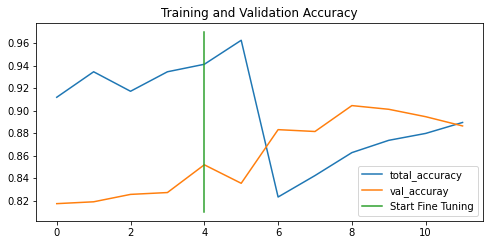

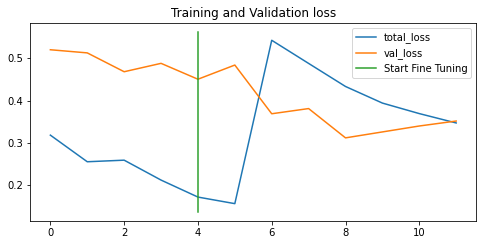

In [164]:
# How did fin_tuning go with more data?
compare_history(history_3, history_4, initial_epochs = 5)

## Viewing our experiment data on Tensorboard


In [ ]:
# View tesnorboard logs of transfer learing modelling experiments (should ~ 4 models)
# Upload Tensorboard dev records
!tensorboard dev upload --logdir ./transfer_learning \
 --name "Transfer learning experimnets with 101 Food101 classes" \
 --description "a " \
 --one_shot